In [1]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

sys.path.append('../')
sys.path.append('../Lib')
sys.path.append('../Models')
sys.path.append('../Protocols')
from cell_models import kernik, protocols, paci_2018

import mod_protocols
import protocol_lib
import mod_kernik as kernik
import mod_trace as trace
from Models.br1977 import BR1977
from ord2011 import ORD2011
import model_response

In [34]:
trial_conditions = "ORD2011_360_51_4_-121_61_10_5"
prestep = 5000
window = 10
step_size = 5
holding_step = 500
only_end = False
with_artefact =False
model_name = trial_conditions.split('_')[0]

path_to_data = f"ga_results/{trial_conditions}"
files = os.listdir(path_to_data)
for f in files:
    if ('pkl' in f) and (f'p{prestep}' in f) and (f'h{holding_step}' in f) and (f'oe{only_end}' in f):
        file_name = f
print(file_name)
final_protocol = pickle.load(open(f"{path_to_data}/{file_name}", 'rb'))
# print("="*50)
# print(final_protocol)
# print("="*50)
print(f'The protocol is {final_protocol.get_voltage_change_endpoints()[-1]} ms')

# times = np.arange(0, short_protocol.get_voltage_change_endpoints()[-1], 1)         
# print(times.shape)
# short_protocol.plot_voltage_clamp_protocol(times)    

ORD2011_360_51_4_-121_61_10_5_h500_p5000_oeFalse_aFalse.pkl
The protocol is 11279.940065304285 ms


In [35]:
start_time = time.time()

currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_CaL', 'I_K1', 'I_NaL' ]               
tr = None
if model_name=='ORD2011' :
    model = ORD2011(final_protocol)
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='OHara2017':
    model = '../mmt-model-files/ohara-cipa-v1-2017_VC.mmt'
    tr = model_response.get_model_response_with_myokit(model, final_protocol, prestep=prestep)
elif model_name=='BR1977' :
    currents = ['I_Na', 'I_si', 'I_K1', 'I_x1']
    model = BR1977(final_protocol)  
    tr = model_response.get_model_response_JK(model, final_protocol, prestep=prestep)
elif model_name=='Kernik':
    currents = ['I_Na', 'I_Kr', 'I_Ks', 'I_To', 'I_F', 'I_CaL', 'I_K1'] 
    k = kernik.KernikModel(is_exp_artefact=True)        
    tr = k.generate_response(final_protocol, is_no_ion_selective=False)

print("--- %s seconds ---"%(time.time()-start_time))

--- 18.299189567565918 seconds ---


In [36]:
start_time = time.time()
current_contributions = tr.current_response_info.get_current_contributions( time=tr.t, window=window, step_size=step_size)
total_current = tr.current_response_info.get_current_summed()
c_li = {}
for current_name in currents:
    c = []
    for t in tr.t:    
        idx = current_contributions['Time Mid'].sub(t).abs().idxmin()
        c.append(current_contributions[current_name].loc[idx])        
    c_li[current_name] = c
print("--- %s seconds ---"%(time.time()-start_time))

--- 35.49902677536011 seconds ---


In [37]:
current_contributions

,Time Start,Time End,Time Mid,I_Na,I_NaL,I_To,I_CaL,I_CaNa,I_CaK,I_Kr,I_Ks,I_K1,I_NaCa,I_NaCa_ss,I_NaK,I_Kb,I_Nab,I_Cab,I_pCa
0,0,10,5.0,6.640933e-03,0.000234,0.000229,0.000002,1.328943e-07,5.016379e-10,0.000006,2.935247e-09,0.870846,0.013990,0.003310,0.075630,0.000116,0.013678,0.015267,0.000051
1,5,15,10.0,6.641015e-03,0.000234,0.000229,0.000002,1.328958e-07,5.016385e-10,0.000006,2.936330e-09,0.870848,0.013989,0.003310,0.075629,0.000116,0.013678,0.015267,0.000051
2,10,20,15.0,6.641075e-03,0.000234,0.000229,0.000002,1.328968e-07,5.016389e-10,0.000006,2.937111e-09,0.870850,0.013988,0.003310,0.075628,0.000116,0.013678,0.015267,0.000051
3,15,25,20.0,6.641134e-03,0.000234,0.000229,0.000002,1.328978e-07,5.016393e-10,0.000006,2.937891e-09,0.870851,0.013987,0.003309,0.075627,0.000116,0.013678,0.015267,0.000051
4,20,30,25.0,6.641194e-03,0.000234,0.000229,0.000002,1.328988e-07,5.016398e-10,0.000006,2.938668e-09,0.870853,0.013986,0.003309,0.075626,0.000116,0.013678,0.015268,0.000051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2249,11245,11255,11250.0,1.901405e-06,0.159371,0.011111,0.576744,4.873468e-02,8.846149e-03,0.002771,2.037858e-03,0.003932,0.041604,0.078535,0.046016,0.016161,0.002343,0.001737,0.000056
2250,11250,11260,11255.0,8.206834e-07,0.144342,0.011450,0.598538,5.169697e-02,1.002528e-02,0.002797,2.196383e-03,0.003186,0.040317,0.071336,0.043701,0.016671,0.002139,0.001551,0.000054
2251,11255,11265,11260.0,3.563224e-07,0.130465,0.011726,0.618573,5.465363e-02,1.132220e-02,0.002832,2.353344e-03,0.002577,0.038751,0.064788,0.041437,0.017140,0.001949,0.001382,0.000052
2252,11260,11270,11265.0,1.563201e-07,0.117743,0.011927,0.636729,5.759305e-02,1.274453e-02,0.002881,2.508558e-03,0.002081,0.036988,0.058933,0.039248,0.017574,0.001772,0.001228,0.000050


In [38]:
max_contributions = tr.current_response_info.get_max_current_contributions(tr.t, window=window, step_size=step_size)
max_contributions

,Current,Contribution,Time Start,Time End
0,I_Na,0.964616,565.0,575.0
1,I_NaL,0.524284,11175.0,11185.0
2,I_To,0.202769,7355.0,7365.0
3,I_CaL,0.856075,595.0,605.0
4,I_CaNa,0.081944,8815.0,8825.0
5,I_CaK,0.389354,7360.0,7370.0
6,I_Kr,0.717342,1715.0,1725.0
7,I_Ks,0.477979,5635.0,5645.0
8,I_K1,0.991809,11130.0,11140.0
9,I_NaCa,0.237938,7160.0,7170.0


In [163]:
def plot_1d(ax, x, ys, title=None, colors=None, ylabel=None, xlim=None, ylim=None):
    
    for i, (key, value) in enumerate(ys.items()):        
        c = None
        if colors:  
            c = colors[i]
        ax.plot( x, value, label=key, color=c, linewidth=2)               
        
    if title:
        ax.set_title(ylabel)
    if xlim:
        ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        ax.set_ylim(ylim[0], ylim[1])    
    if ylabel:
        ax.set_ylabel( ylabel, fontsize=14) 
    ax.set_xlabel('Time (ms)', fontsize=14)  
    ax.tick_params( axis="x", labelsize=14)
    ax.tick_params( axis="y", labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)     
    ax.legend(loc=2, prop={'size': 14})    
    # ax.grid()
    
    return ax

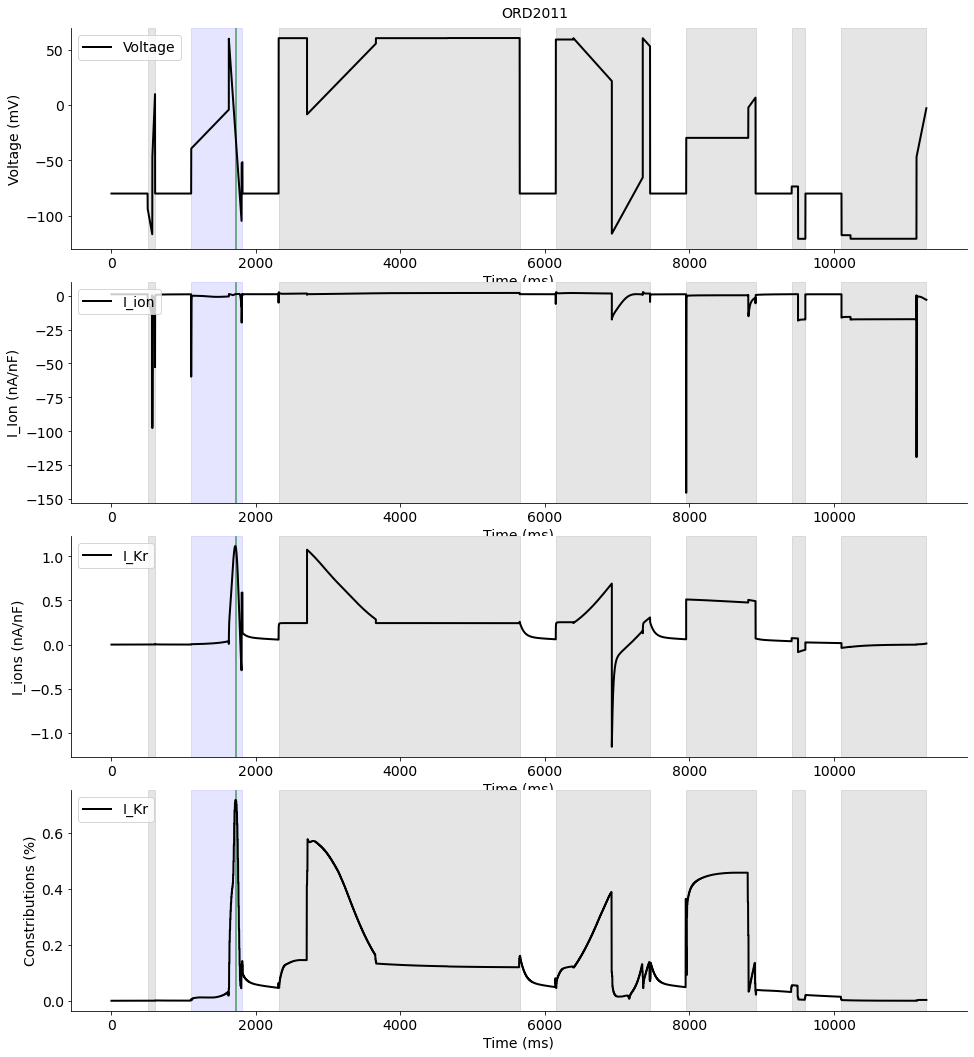

In [167]:
'''
Plot
'''
fig, axes = plt.subplots(4,1, figsize=(15,15))    
fig.suptitle(model_name, fontsize=14)

current_name = 'I_Kr'
xlim = None 
ylim = None

##
plot_1d(axes[0], x=tr.t, ys={'Voltage' : final_protocol.get_voltage_clamp_protocol(tr.t)}, ylabel='Voltage (mV)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[1], x=tr.t, ys={'I_ion' : tr.current_response_info.get_current_summed()}, ylabel='I_Ion (nA/nF)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[2], x=tr.t, ys={current_name : tr.current_response_info.get_current([current_name]) }, ylabel=f'I_ions (nA/nF)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[-1], x=tr.t, ys={current_name : c_li[current_name] }, ylabel='Constributions (%)', colors=['k'], xlim=xlim, ylim=ylim)

##
contribution = max_contributions[max_contributions["Current"]==current_name]['Contribution'].values[0]
start = max_contributions[max_contributions["Current"]==current_name]['Time Start'].values[0]
end = max_contributions[max_contributions["Current"]==current_name]['Time End'].values[0]         
for i in range(4):
    axes[i].axvspan(start, end, color='g', alpha=0.4)  
    
##
total_duration = holding_step
for i, name in enumerate( currents):  
    ##
    short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))                             
    for j in range(4):            
        axes[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if name==current_name else 'k', alpha=.1)                        
    total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
    

# ax_im = axes[2].scatter(tr.t, tr.current_response_info.get_current([current_name]), c=c_li[current_name], cmap=cm.copper, vmin=0, vmax=1)
# fig = plt.gcf()
# cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
# fig.colorbar(ax_im, cax=cbar_ax)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig( f"{path_to_data}/{trial_conditions}_h{holding_step}_p{prestep}_oe{only_end}_a{with_artefact}.jpg", dpi=200)
plt.close(fig)

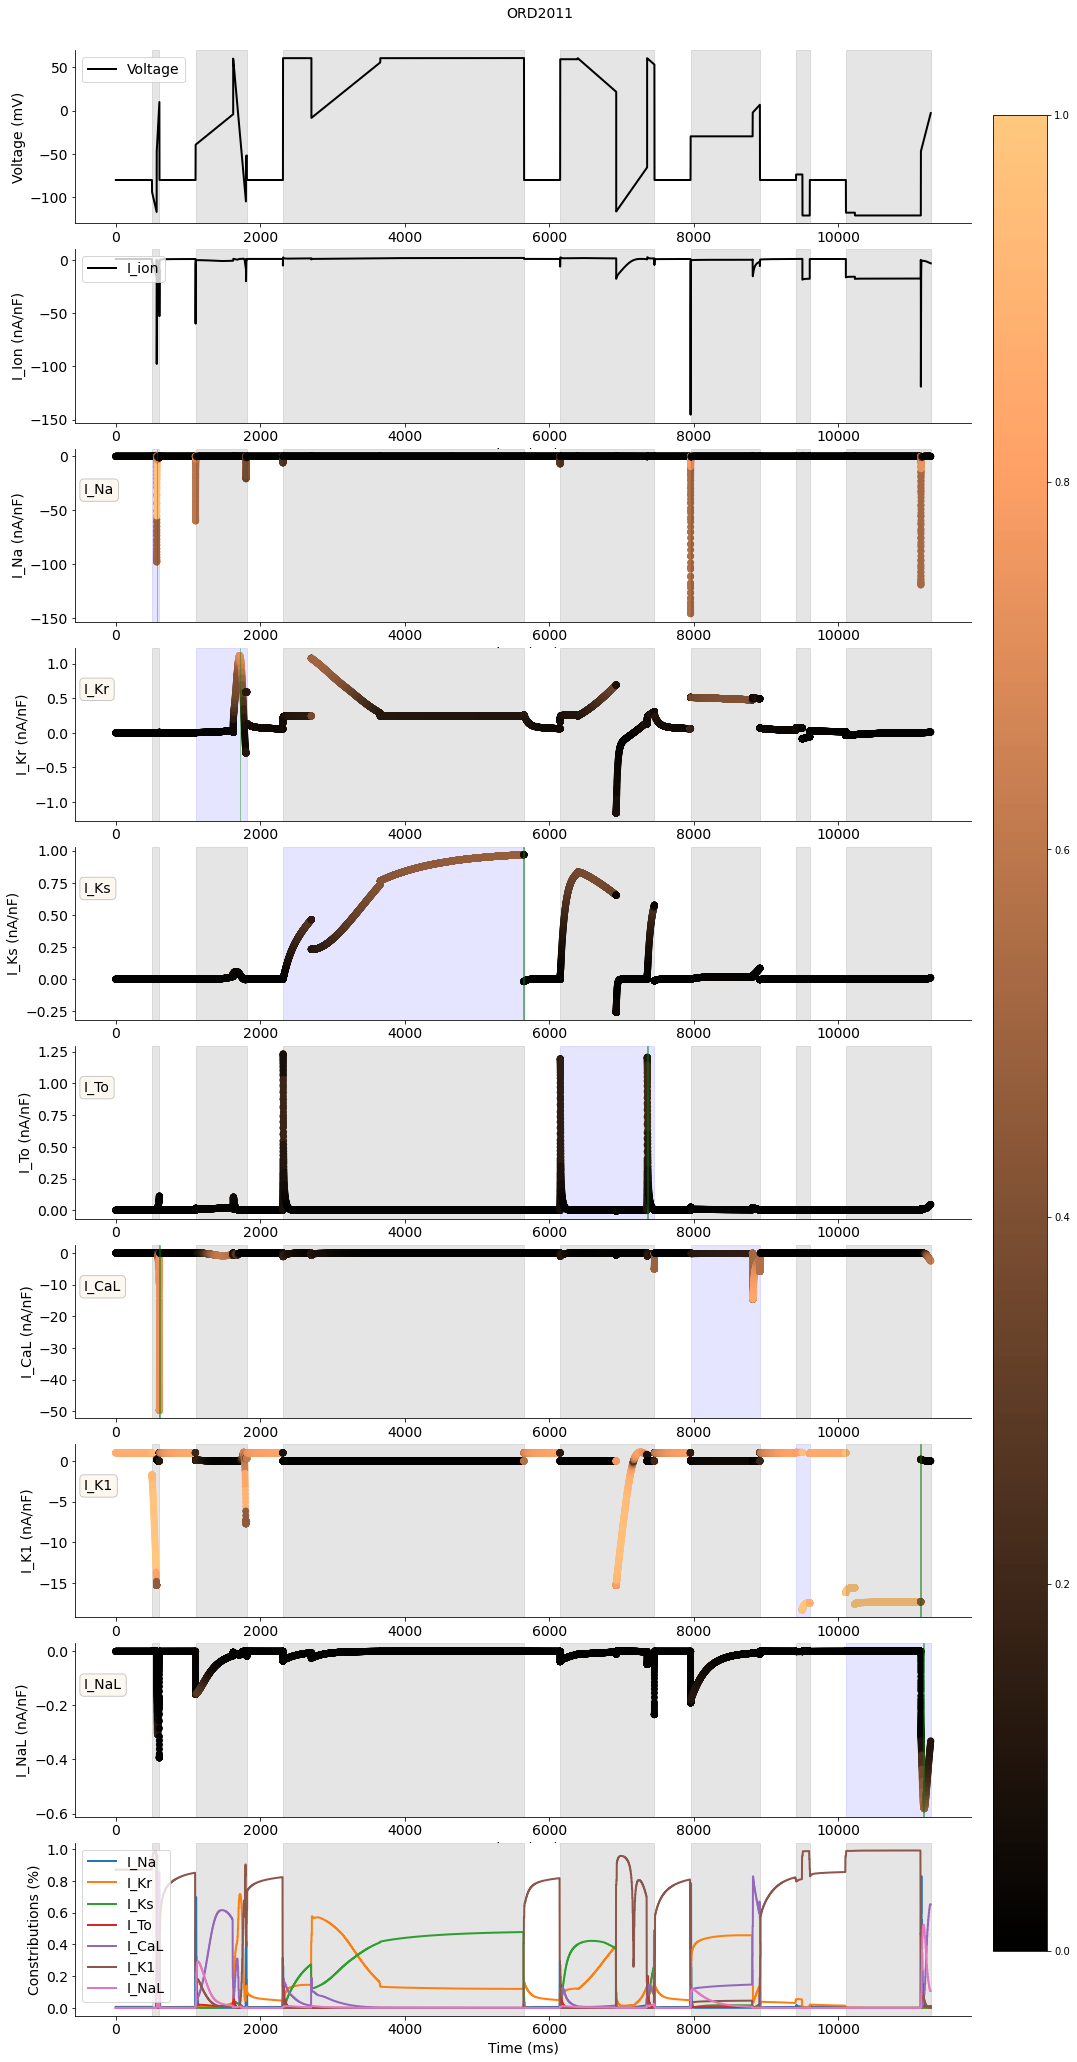

In [169]:
'''
Plot
'''
fig, axes = plt.subplots(len(currents)+3,1, figsize=(15,30))    
fig.suptitle(model_name, fontsize=14)

xlim = None # model_scipy.times.min(), model_scipy.times.max()
ylim = None

plot_1d(axes[0], x=tr.t, ys={'Voltage' : final_protocol.get_voltage_clamp_protocol(tr.t)}, ylabel='Voltage (mV)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[1], x=tr.t, ys={'I_ion' : tr.current_response_info.get_current_summed()}, ylabel='I_Ion (nA/nF)', colors=['k'], xlim=xlim, ylim=ylim)
plot_1d(axes[-1], x=tr.t, ys=c_li, ylabel='Constributions (%)')
# plot_1d(axes[-1], x=tr.t, ys={current_name : c_li[current_name] }, ylabel='Constributions (%)', colors=['k'], xlim=xlim, ylim=ylim)

total_duration = holding_step
for i, name in enumerate( currents):        
    ax = axes[i+2]
    
    ##
    short_protocol = pickle.load(open(f"{path_to_data}/short_{name}_p{prestep}_oe{only_end}_a{with_artefact}.pkl", 'rb'))                             
    for j in range(len(currents)+3):                      
        axes[j].axvspan(total_duration, total_duration+short_protocol.get_voltage_change_endpoints()[-1], color='b' if i+2==j else 'k', alpha=.1)                        
    total_duration += short_protocol.get_voltage_change_endpoints()[-1]+holding_step
      
    ##
    ax_im = ax.scatter(tr.t, tr.current_response_info.get_current([name]), c=c_li[name], cmap=cm.copper, vmin=0, vmax=1, label=[name, name])                
    
    ##
    contribution = max_contributions[max_contributions["Current"]==name]['Contribution'].values[0]
    start = max_contributions[max_contributions["Current"]==name]['Time Start'].values[0]
    end = max_contributions[max_contributions["Current"]==name]['Time End'].values[0]         
    ax.axvspan(start, end, color='g', alpha=0.4)   
    
    #     ax[i].set_title(name)
    ax.set_xlabel('Time (ms)', fontsize=14)           
    ax.set_ylabel(f'{name} (nA/nF)', fontsize=14) 
    ax.tick_params(axis="x", labelsize=14)
    ax.tick_params(axis="y", labelsize=14)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)             
    ax.text(0.01, 0.8, name, transform=ax.transAxes, fontsize=14, verticalalignment='top', c='k',  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.2))            
    if xlim :
        ax_temp.set_xlim(model_scipy.times.min(), model_scipy.times.max())
    if ylim :
        ax_temp.set_ylim(ylim[0], ylim[1])
    
fig = plt.gcf()
cbar_ax = fig.add_axes([0.92, 0.08, 0.05, 0.85])
fig.colorbar(ax_im, cax=cbar_ax)
plt.subplots_adjust(left=0.07, bottom=0.05, right=0.9, top=0.96, wspace=0.5, hspace=0.15)
plt.show()
fig.savefig( f"{path_to_data}/{trial_conditions}_h{holding_step}_p{prestep}_oe{only_end}_a{with_artefact}.jpg", dpi=200)
plt.close(fig)

In [170]:
print("Complete")

Complete
